## Core Idea

Geometry and pattern matching approach to predict scaler coupling constant.

The hypothesis of this kernel:
1. If we have two similar sets of atoms with the same distances between them and the same coupling types - the scalar coupling constant should be very close.
2. Closer atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with further away.

Each atom is described with 3 cartesian coordinates. One problem is that each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates, let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

In [48]:
# predict_scalar_coupling_approach.gif

from IPython.display import Image
Image(url='predicting_scalar_coupling_approach.gif')  

# Magnitude of J-coupling
For 1H–1H coupling, the magnitude of J provides information on the proximity of the coupling partners. Generally speaking 2-bond coupling (i.e. 1H–C–1H) is stronger than three-bond coupling (1H–C–C–1H). The magnitude of the coupling also provides information on the dihedral angles relating the coupling partners, as described by the Karplus relationship.

## why 1JHC for methane is 84.80-ish?
I think it's because these structures are the result of a QM simulation at 0 K, so it doesn't reflect reality at higher temperatures, or include dynamics.
Experimentally the 1JHC coupling: https://www.sciencedirect.com/science/article/pii/0022236491900755)
The bond lengths: http://www.colby.edu/chemistry/webmo/CH4.html

## Load Everything

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


from sklearn.model_selection import KFold,train_test_split
# KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

from sklearn.metrics import mean_absolute_error

import seaborn as sns

from lightgbm import LGBMRegressor

In [50]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [51]:
# pd.set_option(): https://www.tutorialspoint.com/python_pandas/python_pandas_options_and_customization.htm
# Options and Customization
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: https://datacarpentry.org/python-ecology-lesson/04-data-types-and-format/

In [52]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv('train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
print(train_csv.head(25))





/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


    molecule_index  atom_index_0  atom_index_1  type  scalar_coupling_constant
id                                                                            
0   1               1             0             1JHC  84.807602               
1   1               1             2             2JHH -11.257000               
2   1               1             3             2JHH -11.254800               
3   1               1             4             2JHH -11.254300               
4   1               2             0             1JHC  84.807404               
5   1               2             3             2JHH -11.254100               
6   1               2             4             2JHH -11.254800               
7   1               3             0             1JHC  84.809303               
8   1               3             4             2JHH -11.254300               
9   1               4             0             1JHC  84.809502               
10  2               1             0             1JHN

In [53]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()
print('Total # of molecules in train.csv: ', len(train_csv['molecule_index'].unique()))

Shape:  (4659076, 5)
Total:  88522828
Total # of molecules in train.csv:  85012


In [54]:
output_result_csv = pd.read_csv('sample_output_result.csv', index_col='id')

/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [55]:
test_csv = pd.read_csv('test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
print(test_csv.head(25))
print(test_csv.shape)

         molecule_index  atom_index_0  atom_index_1  type
id                                                       
4659076  4               2             0             2JHC
4659077  4               2             1             1JHC
4659078  4               2             3             3JHH
4659079  4               3             0             1JHC
4659080  4               3             1             2JHC
4659081  14              3             0             1JHC
4659082  14              3             1             2JHC
4659083  14              3             4             2JHH
4659084  14              3             5             2JHH
4659085  14              3             6             3JHH
4659086  14              3             7             3JHH
4659087  14              4             0             1JHC
4659088  14              4             1             2JHC
4659089  14              4             5             2JHH
4659090  14              4             6             3JHH
4659091  14   

In [56]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv('structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
print(structures_csv.head(50))
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
print(structures_csv.head(50))



    molecule_index  atom_index atom         x         y         z
0   1               0           C   -0.012698  1.085804  0.008001
1   1               1           H    0.002150 -0.006031  0.001976
2   1               2           H    1.011731  1.463751  0.000277
3   1               3           H   -0.540815  1.447527 -0.876644
4   1               4           H   -0.523814  1.437933  0.906397
5   2               0           N   -0.040426  1.024108  0.062564
6   2               1           H    0.017257  0.012545 -0.027377
7   2               2           H    0.915789  1.358745 -0.028758
8   2               3           H   -0.520278  1.343532 -0.775543
9   3               0           O   -0.034360  0.977540  0.007602
10  3               1           H    0.064766  0.020572  0.001535
11  3               2           H    0.871790  1.300792  0.000693
12  4               0           C    0.599540  0.000000  1.000000
13  4               1           C   -0.599540  0.000000  1.000000
14  4     

In [57]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
print(structures_csv.memory_usage())
print('Total # of molecules: ', len(structures_csv['molecule_index'].unique()))

Shape:  (2358875, 6)
Total:  42459878
Index             128    
molecule_index    9435500
atom_index        2358875
atom              2358875
x                 9435500
y                 9435500
z                 9435500
dtype: int64
Total # of molecules:  130789


## Build Distance Dataset

In [58]:
# drop(axis=0/1): https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean

def build_type_dataframes(base, structures, coupling_type):
    
    # from base dataframe, select rows that have the specified coupling_type, and then drop the column of that type
    # then make copy
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    
    # reset id
    base = base.reset_index()
    
    # set data type for the newly created id column
    base['id'] = base['id'].astype('int32')
    
    # select molecule structures that match molecule_index in base dataframe file
    # Note that molecule_name in the oririnal file were converted into molecule_index in the new dataframe
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    
    # return base dataframe and structure dataframe that only have rows with the specified coupling type
    return base, structures

In [59]:
# merge example: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html

# df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'],
#                     'value_1': [1, 2, 3, 5]})
# df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'],
#                     'value_2': [5, 6, 7, 8]})
# print(df1)
# print(df2)
# print(df1.merge(df2, left_on='lkey', right_on='rkey'))
# print(df1.merge(df2, left_on=['lkey','value_1'], right_on=['rkey','value_2']).drop(['value_2'],axis=1))

In [60]:
def add_coordinates(base, structures, index):
    
    # select rows from both base dataframe and structure dataframe
    # such that moleucle_index and atom_index both match.
    # Basically this function is choosing every atom with specified coupling type from base dataframe,
    # then, also select coresponding coordinates from structures dataframe.
    # For example, 3 H atoms in ammonia molecule from base dataframe
    # then select coordinates from structures dataframe
    # In ammonia case, I need to add coordinates for Hydrogen and Nitrogen, so I need to do this
    # with atom_index_0 and atom_index_1
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    
    # rename columns for structure dataframe part after merging
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [61]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [62]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    # select and merge all rows that have the same molecule_index
    # At this point, putting all 1JHN molecules for each x_c, y_c, z_c
    # so I need to drop atoms that make center atoms
    # For ammonia case, now I have 12 rows. I have 3 atom centers. For each center, I have 4 xyz coordinates.
    # But I need to drop rows with coordinates that form centers.
    
    # drop rows that have atoms to make centers.
    # Now, I have 2 atoms for each center.
    # For ammonia case, for a center between atom_index_1=0 (Nitrogen) and atom_index_0=0 (Hydrogen)
    # This center has atom_index = 2 and 3
    # Other 2 centers follow the same way, so total 6 rows.
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [63]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

# Euclidean distance
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

# calculate all distance among atoms
# d_1_0 to d_9_1, around core atoms to far atoms. But, limit the total # of distances to be calculated,
# assuming that far atoms have less and less influence to scalar coupling of core atoms.
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [64]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

# test
# col_list = ['molecule_index', 'atom_index_0', 'atom_index_1', 'atom_2', 'atom_3',
#        'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'x_2',
#        'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2', 'y_3', 'y_4',
#        'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6',
#        'z_7', 'z_8', 'z_9']

# n_atoms = 1 + max([int(c.split('_')[1]) for c in col_list if c.startswith('x_')])
# print(n_atoms)
# output is 10

# test
# for i in range(1,10):
#         for vi in range(min(4, i)):
#             print(i, vi)
# output
# 1 0
# 2 0
# 2 1
# 3 0
# 3 1
# 3 2
# 4 0
# 4 1
# 4 2
# 4 3
# 5 0
# 5 1
# 5 2
# 5 3
# 6 0
# 6 1
# 6 2
# 6 3
# 7 0
# 7 1
# 7 2
# 7 3
# 8 0
# 8 1
# 8 2
# 8 3
# 9 0
# 9 1
# 9 2
# 9 3


In [65]:
# Looks like this function was not used

# def add_n_atoms(base, structures):
#     dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
#     return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [66]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    
    # build_type_dataframes()
    # return base dataframe and structure dataframe that only have rows with the specified coupling type
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    
    # add_coordinates()
    # add all coordinates of atoms in atom_index_0, all 3 Hydrogen atoms in ammonia case 
    base = add_coordinates(base, structures, 0)
    # add all cordinates of coresponsing atoms in atom_index_1, Nitrogen atom for each Hydrogen in ammonia case
    base = add_coordinates(base, structures, 1)
    
    # drop atom_0 column (H in this case) and atom_1 column (N in this case)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    # drop id column
    atoms = base.drop('id', axis=1).copy()
    
    # drop scalar_coupling_constant column, but why???
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
    
    # calculate all coordinates between all Hydrogen and Nitrogen
    # in ammonia case for example and store as x_c, y_c, and z_c
    add_center(atoms)
    
    # drop x_0 to z_1 columns since I have x_c, y_c, z_c
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    
    # merge_all_atoms()
    # To have coordinates of centers (x_c, y_c, z_c) and non-core atoms for each center
    atoms = merge_all_atoms(atoms, structures)
    
    # calculate the distance between centers and all non-core atoms, then store it in d_c column
    # Euclidean distance
    add_distance_to_center(atoms)
    
    # Now I have distances, so drop centers and atom_index
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    
    # sorting distances with one atom center, and then sorting distances with another atom center, and so forth
    # Note: inplace means the existing data is modified, and without inplace, the existing data is copied to 
    # another place and some action is performed on the new data. So the existing data is preserved.
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    
    # groupby: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
    # Need to use groupby Probably to cumcount # of atoms
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    
    # cumcount: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.cumcount.html
    atoms['num'] = atom_groups.cumcount() + 2
    
    # atoms dataframe are already sorted by distance, so d_c column is not necessary now
    atoms = atoms.drop(['d_c'], axis=1)
    # print(atoms[80:180])
    
    # In case of molecule 76, for example, from the center between core Hydrogen and core Nitrogen,
    # there are total 10 distances. By setting n_atoms = 10 as default,
    # the two rows with farthest distances are dropped. 
    atoms = atoms[atoms['num'] < n_atoms]
    # print(atoms[80:180])
    # print(atoms.head(14))
    
    # unstack(): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    # print(atoms.head(10))
    # print(atoms.columns)
    
    # changing column names
    # Note: because 'molecule_index', 'atom_index_0', 'atom_index_1', 'num' are set to index,
    # they don't appear in atoms.columns
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    # print(atoms.head(10))
    
    # reset index, now all column names appear by atoms.columns
    atoms = atoms.reset_index()
    # print(atoms.columns)
    
    # downcast back to int8, setting data types
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    # lengths of base dataframe and atoms dataframe are the same: 43680
    # merge columns from base dataframe:
    # ['id', 'molecule_index', 'atom_index_0', 'atom_index_1','scalar_coupling_constant',
    # 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1']
    # merge columns from atoms dataframe:
    # ['molecule_index', 'atom_index_0', 'atom_index_1',
    # 'atom_2', 'atom_3','atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'x_2',
    # 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2', 'y_3', 'y_4',
    # 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6',
    # 'z_7', 'z_8', 'z_9']
    # to form columns in full dataframe:
    # ['id', 'molecule_index', 'atom_index_0', 'atom_index_1','scalar_coupling_constant',
    # 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
    # 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
    # 'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
    # 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
    # 'z_5', 'z_6', 'z_7', 'z_8', 'z_9']
    full = add_atoms(base, atoms)
    
    # add_distances()
    # calculate distances around core atoms and store them in d_x_x columns
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

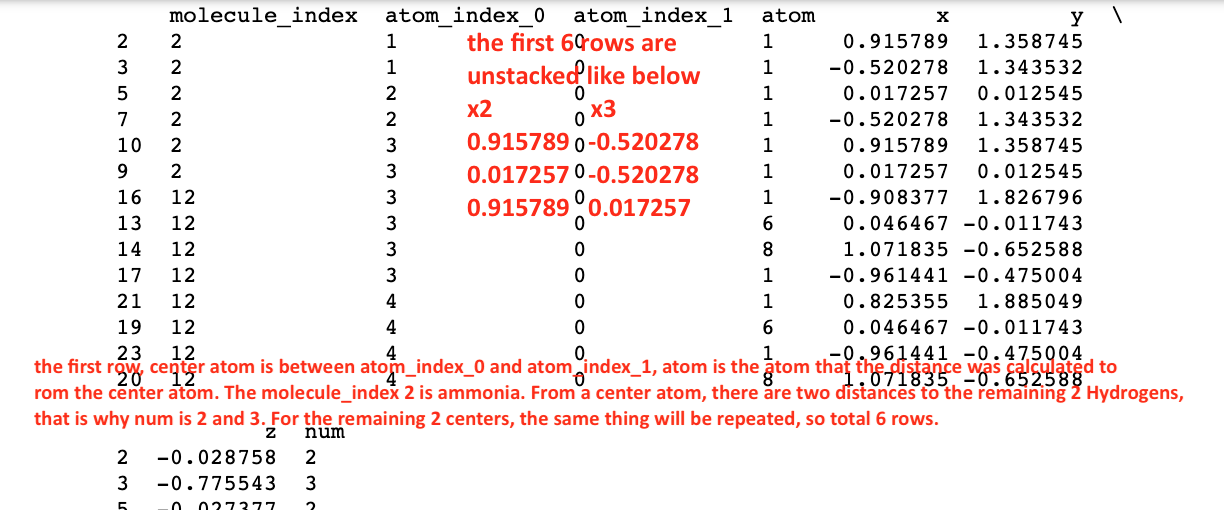

In [67]:
from IPython.display import Image
Image(filename='before_index_unstack.png')

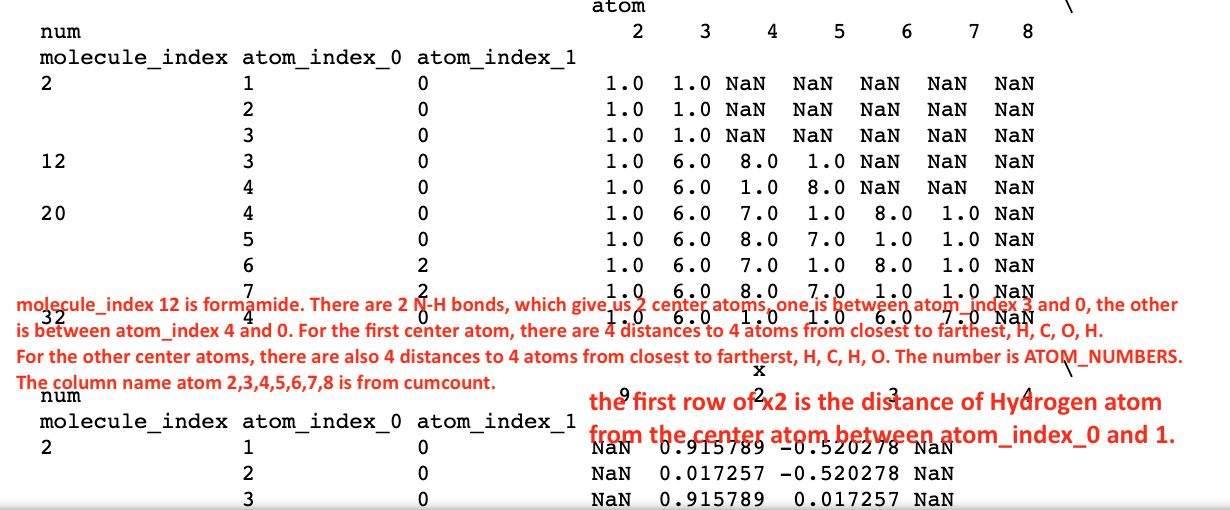

In [68]:
Image(filename='after_index_unstack.png')

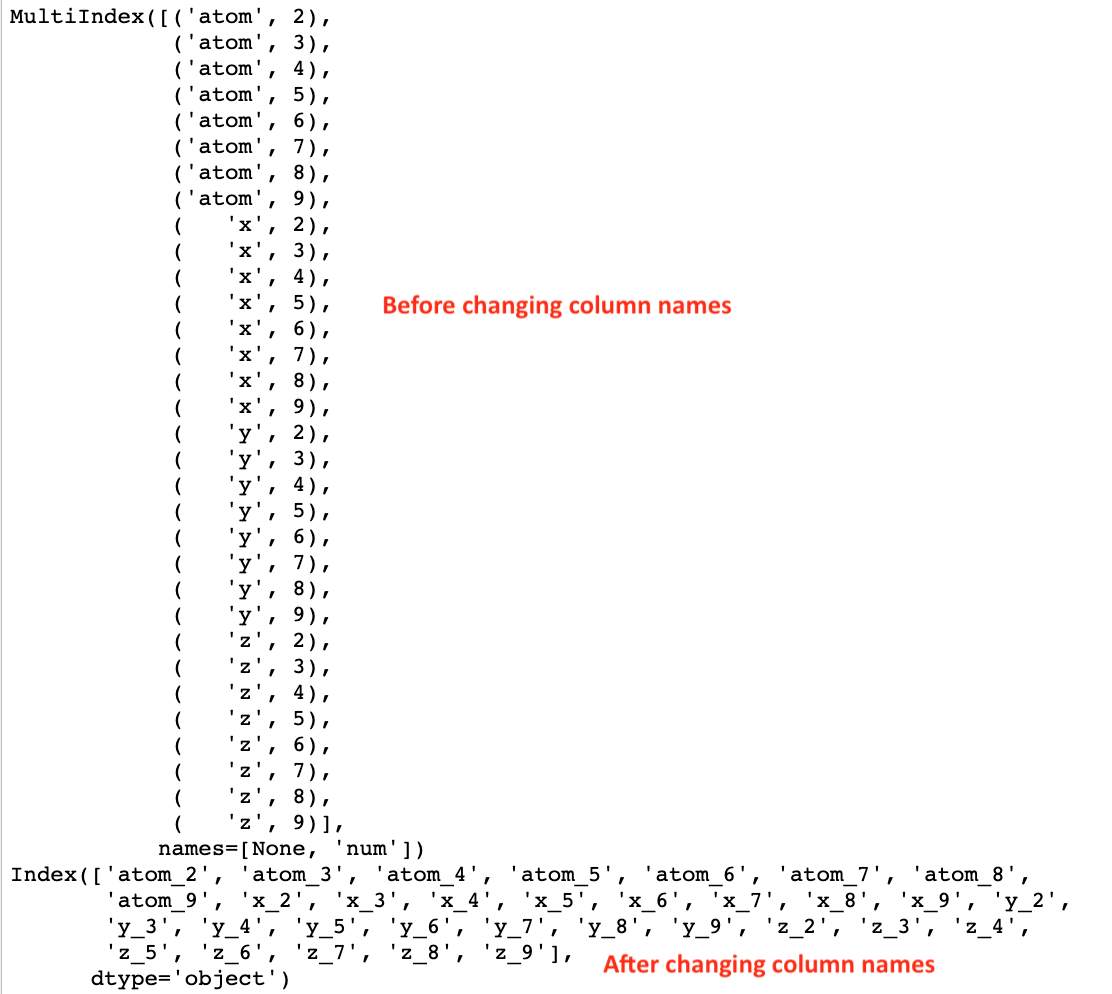

In [69]:
Image(filename='before_after_changing_column_names.png')

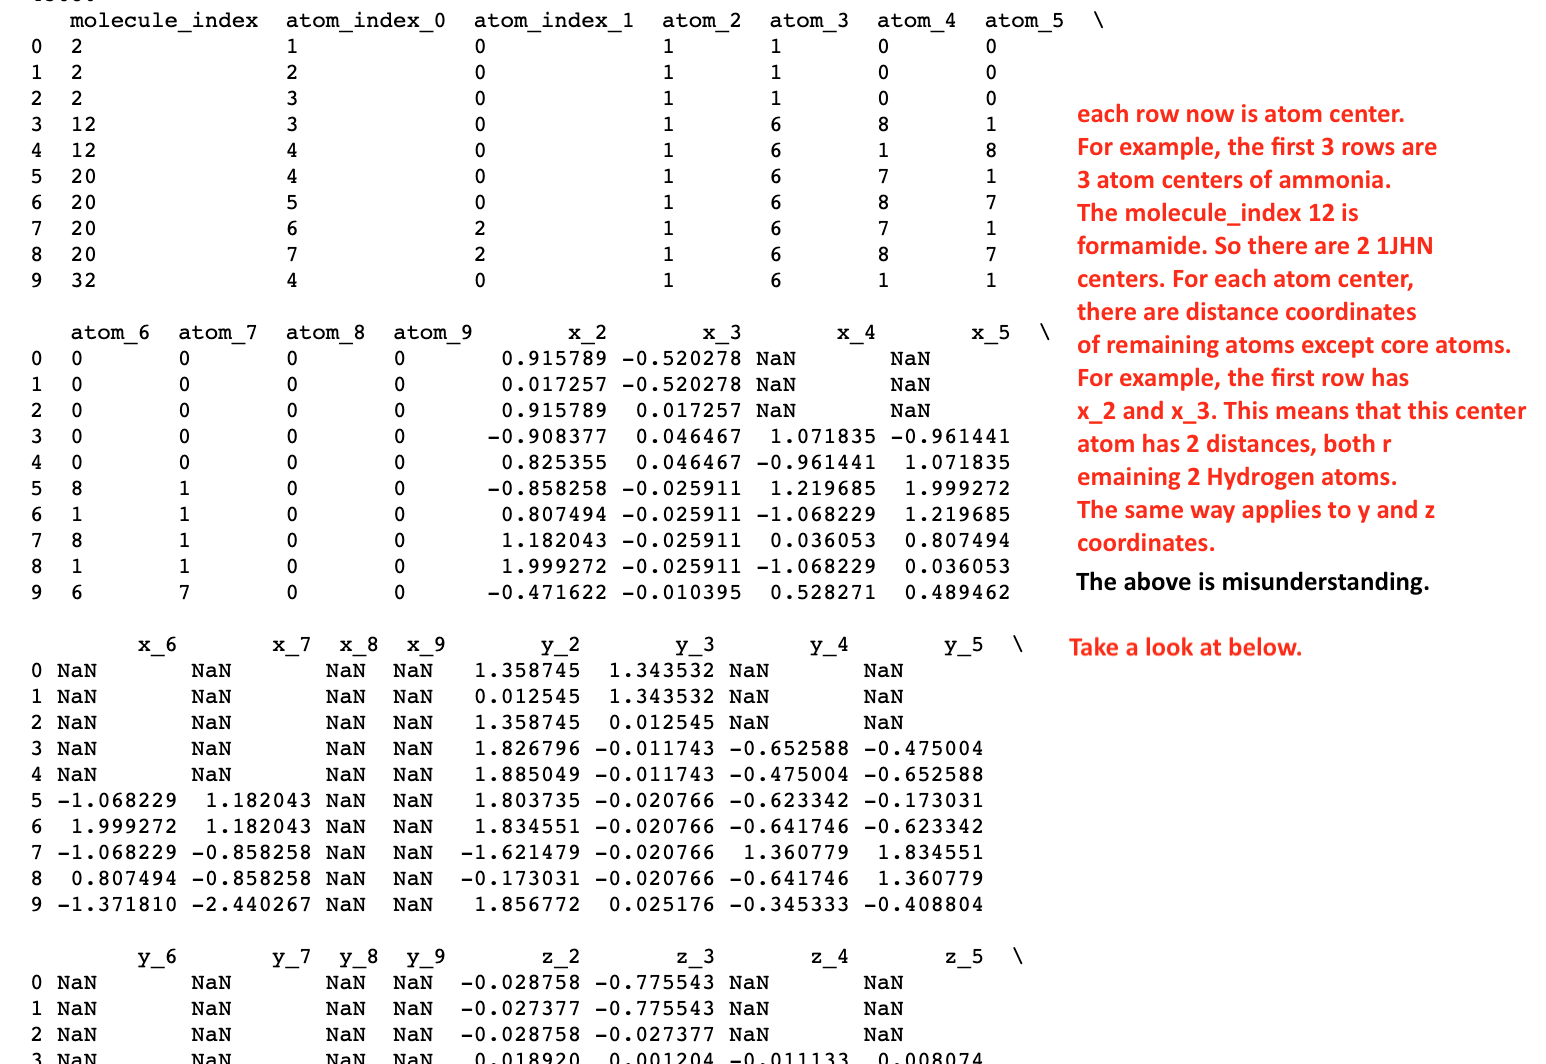

In [70]:
Image(filename='after_changing_column_names.png')

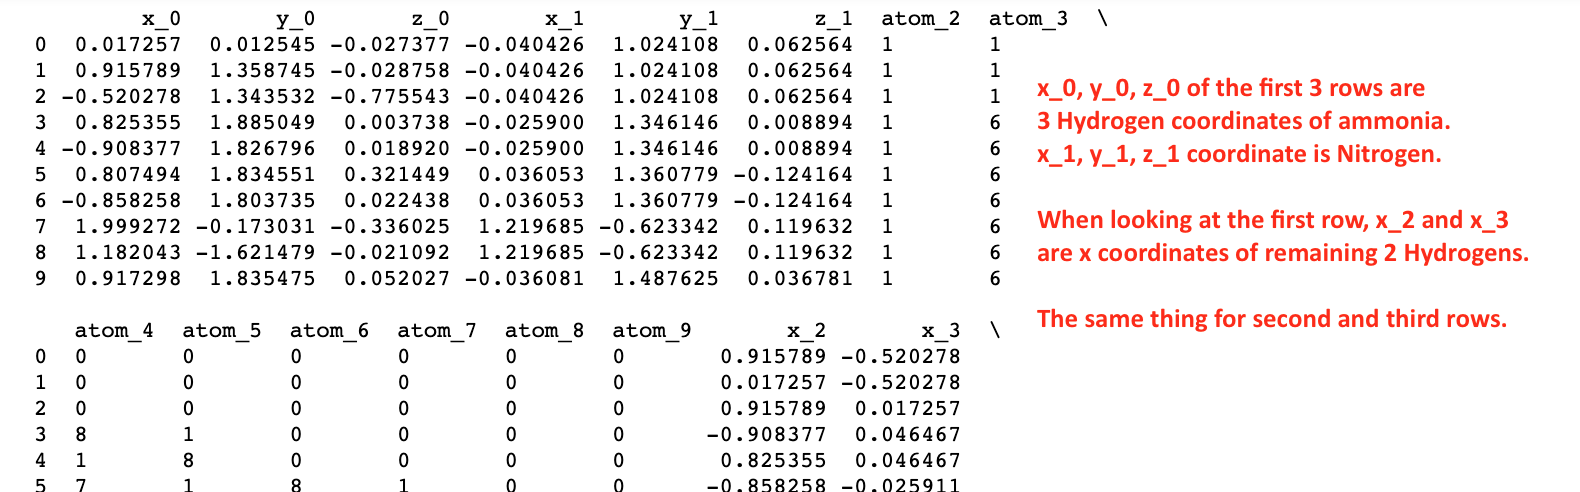

In [71]:
Image(filename='after_add_distances.png')

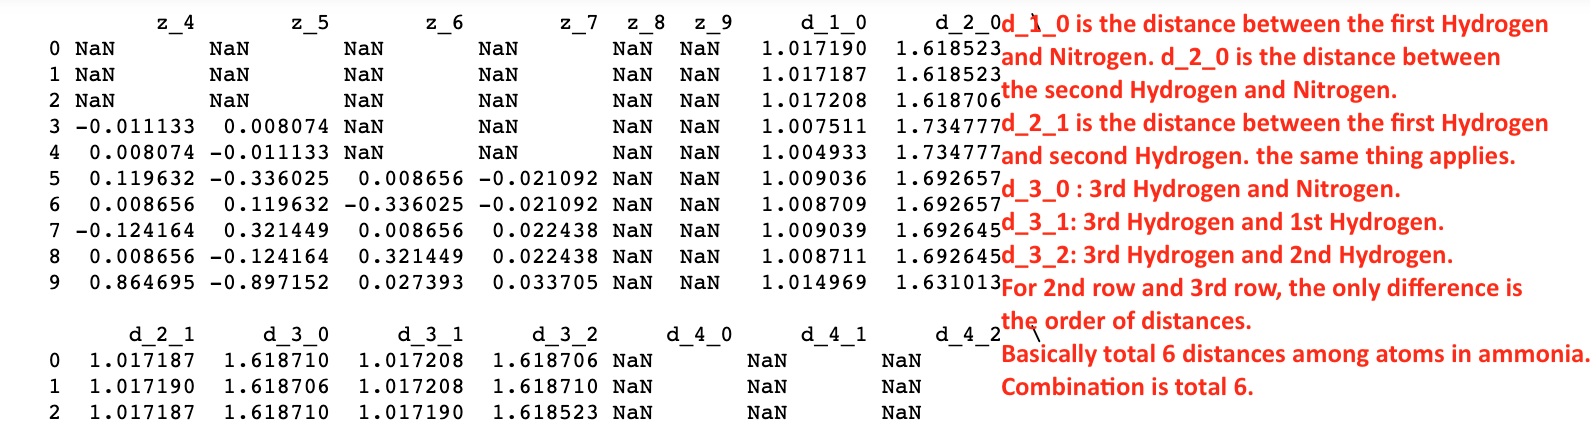

In [72]:
Image(filename='after_add_distances_2.png')

In [73]:
# conditional statements: <expr1> if <conditional_expr> else <expr2>
# https://realpython.com/python-conditional-statements/

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

## experiment LightGBM model with the smallest dataset

In [74]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43680, 73)
CPU times: user 1.35 s, sys: 363 ms, total: 1.72 s
Wall time: 1.75 s


In [75]:
print(full.columns)
print(len(full))
# print(full.head(10))
# In full dataframe, the scalar coupling in each row is the scalar coupling of core atoms (I guess)

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')
43680


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [76]:
df = take_n_atoms(full, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
print(df.columns)
print(df.head(3))
print(len(df))

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
   atom_2  atom_3  atom_4  atom_5  atom_6     d_1_0     d_2_0     d_2_1  \
0  1       1       0       0       0       1.017190  1.618523  1.017187   
1  1       1       0       0       0       1.017187  1.618523  1.017190   
2  1       1       0       0       0       1.017208  1.618706  1.017187   

      d_3_0     d_3_1     d_3_2  d_4_0  d_4_1  d_4_2  d_4_3  d_5_0  d_5_1  \
0  1.618710  1.017208  1.618706  0.0    0.0    0.0    0.0    0.0    0.0     
1  1.618706  1.017208  1.618710  0.0    0.0    0.0    0.0    0.0    0.0     
2  1.618710  1.017190  1.618523  0.0    0.0    0.0    0.0    0.0    0.0     

   d_5_2  d_5_3  d_6_0  d_6_1  d_6_2  d_6_3  scalar_coupling_constant  
0  0.0    0.0    0.0    0.0

In [77]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')
print("X_train (ammonia): \n{}\n\n".format(X_data[:3]))
print("y_train (ammonia): \n{}\n\n".format(y_data[:3]))


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
print(f'X_train: \n{X_train[:4]}\n\n',f'X_val: \n{X_val[:4]}\n\n',f'y_train: \n{y_train[:4]}\n\n',f'y_val: \n{y_val[:4]}\n\n')


X_train (ammonia): 
[[1.        1.        0.        0.        0.        1.01719   1.6185228
  1.0171872 1.6187098 1.0172079 1.6187056 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [1.        1.        0.        0.        0.        1.0171872 1.6185228
  1.01719   1.6187056 1.0172079 1.6187098 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [1.        1.        0.        0.        0.        1.0172079 1.6187056
  1.0171872 1.6187098 1.01719   1.6185228 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]


y_train (ammonia): 
[32.6889 32.6891 32.6905]


X_train: 
[[1.        6.        1.        1.        1.        1.013774  1.6275383
  1.0160719 2.0463681 1.4627149 2.047436  2.3050725 2.0909886 2.9278572
  1.0950602 2.5641537 2.1729996 2.3942215 1.0960515 3.2997756 2.4843767
  2.9675806 2.6519005]
 [1. 

In [78]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering

# LightGBM: parameters
# https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning-control-parameters

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

# objective (string, callable or None, optional (default=None)) – Specify the learning task and the 
# corresponding learning objective or a custom objective function to be used (see note below).
# Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier,
# ‘lambdarank’ for LGBMRanker.

# metric: mae, mean_absolute_error

# verbosity: an option for producing detailed logging information. Be aware, and will probably notice
# if you enable verbose > 0, that printing to the screen is generally a very slow process.
# The algorithm may run an order of magnitude slower, or more, with verbose enabled.

# boosting_type: 'gbdt': traditional Gradient Boosting Decision Tree, aliases: gbrt

# num_leaves: max number of leaves in one tree

# min_data_in_leaf, default = 20, type = int, aliases: min_data_per_leaf, min_data, min_child_samples,
# constraints: min_data_in_leaf >= 0
# minimal number of data in one leaf. Can be used to deal with over-fitting

# max_depth, default = -1, type = int
# limit the max depth for tree model. This is used to deal with over-fitting when #data is small.
# Tree still grows leaf-wise
# <= 0 means no limit

# bagging_freq, default = 0, type = int, aliases: subsample_freq
# frequency for bagging
# 0 means disable bagging; k means perform bagging at every k iteration
# Note: to enable bagging, bagging_fraction should be set to value smaller than 1.0 as well

# bagging_fraction, default = 1.0, type = double, aliases: sub_row, subsample, bagging,
# constraints: 0.0 < bagging_fraction <= 1.0
# like feature_fraction, but this will randomly select part of data without resampling
# can be used to speed up training
# can be used to deal with over-fitting
# Note: to enable bagging, bagging_freq should be set to a non zero value as well

# bagging_seed, default = 3, type = int, aliases: bagging_fraction_seed
# random seed for bagging

# lambda_l1, default = 0.0, type = double, aliases: reg_alpha, constraints: lambda_l1 >= 0.0
# L1 regularization

# lambda_l2, default = 0.0, type = double, aliases: reg_lambda, lambda, constraints: lambda_l2 >= 0.0
# L2 regularization

# feature_fraction, default = 1.0, type = double, aliases: sub_feature, colsample_bytree,
# constraints: 0.0 < feature_fraction <= 1.0
# LightGBM will randomly select part of features on each iteration (tree)
# if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features
# before training each tree
# can be used to speed up training
# can be used to deal with over-fitting

# num_iterations, default = 100, type = int, aliases: num_iteration, n_iter, num_tree, num_trees,
# num_round, num_rounds, num_boost_round, n_estimators, constraints: num_iterations >= 0
# number of boosting iterations
# Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems

# n_jobs: num_threads, default = 0, type = int, aliases: num_thread, nthread, nthreads, n_jobs
# number of threads for LightGBM
# 0 means default number of threads in OpenMP
# for the best speed, set this to the number of real CPU cores, not the number of threads (most CPUs use
# hyper-threading to generate 2 threads per CPU core)
# do not set it too large if your dataset is small (for instance, do not use 64 threads for a dataset with
# 10,000 rows). Be aware a task manager or any similar CPU monitoring tool might report that cores not being
# fully utilized. This is normal. For parallel learning, do not use all CPU cores because this will cause poor
# performance for the network communication. Note: please don’t change this during training, especially 
# when running multiple jobs simultaneously by external packages, otherwise it may cause undesirable errors

# early_stopping_round, default = 0, type = int, aliases: early_stopping_rounds, early_stopping,
# n_iter_no_change
# will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds
# <= 0 means disable

In [79]:
%%time
# LGBRegressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor

model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.420929	valid_1's l1: 0.508208
[200]	training's l1: 0.34444	valid_1's l1: 0.463207
[300]	training's l1: 0.297417	valid_1's l1: 0.441441
[400]	training's l1: 0.265063	valid_1's l1: 0.425778
[500]	training's l1: 0.240024	valid_1's l1: 0.416033
[600]	training's l1: 0.217318	valid_1's l1: 0.407284
[700]	training's l1: 0.200306	valid_1's l1: 0.401882
[800]	training's l1: 0.185605	valid_1's l1: 0.39775
[900]	training's l1: 0.171776	valid_1's l1: 0.393514
[1000]	training's l1: 0.160023	valid_1's l1: 0.390101
[1100]	training's l1: 0.149426	valid_1's l1: 0.387208
[1200]	training's l1: 0.140344	valid_1's l1: 0.384732
[1300]	training's l1: 0.13272	valid_1's l1: 0.38267
[1400]	training's l1: 0.125346	valid_1's l1: 0.380736
[1500]	training's l1: 0.118742	valid_1's l1: 0.379697
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.118742	valid_1's l1: 0.379697
CPU times: user 22 s, sys: 134 ms, tota

-0.9683826511844378

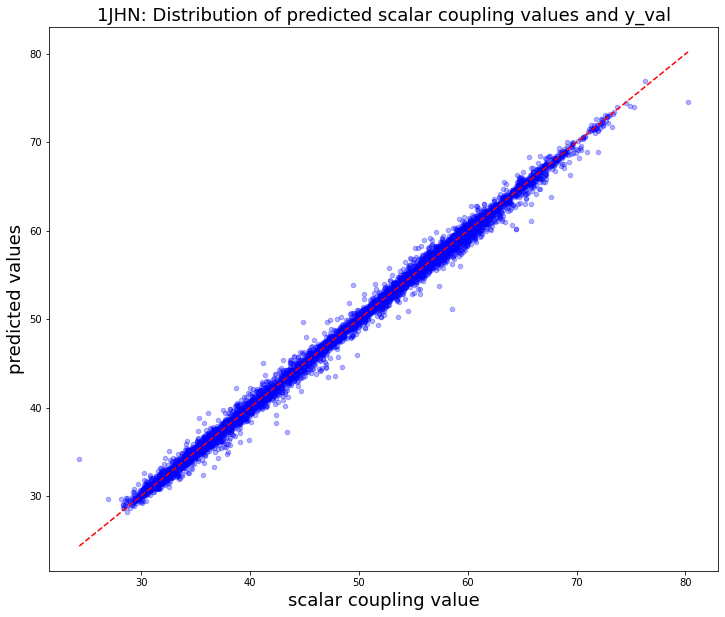

In [34]:
plt.figure(figsize=(12,10))
plt.scatter(y_val, y_pred,alpha=0.3, s=20, c='b', marker='o')
plt.title('1JHN: Distribution of predicted scalar coupling values and y_val', fontsize=18)
plt.xlabel("scalar coupling value", fontsize=18)
plt.ylabel("predicted values", fontsize=18)
plt.plot([min(y_val),max(y_val)],[min(y_val),max(y_val)], "r--")
plt.show()

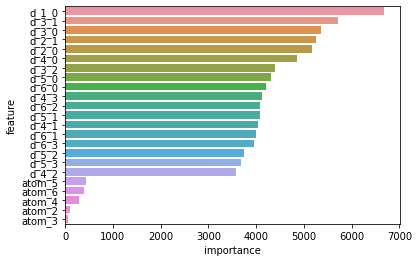

In [35]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

# experiment other models with the smallest dataset

* Lasso
* Ridge
* ElasticNet
* DecisionTreeRegressor
* RandomForestRegressor
* KMeans
* DBSCAN
* MLPRegressor (Multilayer Perceptron)
* GradientBoostingRegressor
* VotingRegressor
* StackingRegressor
* KerasRegressor





In [80]:
%%time

# When I used algorithm for classification problems such as
# SVC, KNN, LogisticRegression, DecisionTreeClassifier, AdaBoostClassifier, MLPClassifier, RandomForestClassifier
# I got an error, "Unknown label type: 'continuous'"
# GaussianNB is also for classification problems


# Using regularized methods for regression
# Lasso
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Lasso_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# Ridge
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Ridge_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# ElasticNet
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'ElasticNet_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# Decision tree regression
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'DecisionTreeRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

## Random forest regression
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'RandomForestRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# n_estimators=1000 gives -0.8611445248284487, also takes a lot of time

# KMeans
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, 
            init='random', 
            n_init=10, 
            max_iter=1000,
            tol=1e-04,
            random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'KMeans_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# DBSCAN
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.fit_predict(X_val)
print(f'DBSCAN_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# MLPRegressor
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=(100,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=0, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'MLPRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')


# ensemble learning models other than RandomForest
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=9, random_state=0, loss='ls')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'GradientBoostingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

## from sklearn.datasets import load_boston
## from sklearn.ensemble import GradientBoostingRegressor
## from sklearn.ensemble import RandomForestRegressor
## from sklearn.linear_model import LinearRegression
## from sklearn.ensemble import VotingRegressor
## reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
## reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
## reg3 = LinearRegression()
## model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
## model.fit(X_train, y_train)
## y_pred = model.predict(X_val)
## print(f'VotingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# # Takes long time to calculate: VotingRegressor_MAE_log: 0.46833474323080804

## from sklearn.linear_model import RidgeCV, LassoCV
## from sklearn.svm import SVR
## estimators = [('ridge', RidgeCV()),
##              ('lasso', LassoCV(random_state=42)),
##               ('svr', SVR(C=1, gamma=1e-6))]
## from sklearn.ensemble import GradientBoostingRegressor
## from sklearn.ensemble import StackingRegressor
## model = StackingRegressor(
##      estimators=estimators,
##     final_estimator=GradientBoostingRegressor(random_state=42))
## model.fit(X_train, y_train)
## y_pred = model.predict(X_val)
## print(f'StackingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
## # Takes a lot of calculation time: StackingRegressor_MAE_log: 0.3828974855958835

## KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor

# def baseline_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(23, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# print(f'KerasRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# # Takes a lot of computing time: KerasRegressor_MAE_log: 0.32364046573638916




Lasso_MAE_log: 1.3380218744277954
Ridge_MAE_log: 0.5069612264633179
ElasticNet_MAE_log: 1.8988251686096191
DecisionTreeRegressor_MAE_log: 0.022618624169804993
RandomForestRegressor_MAE_log: -0.7615371726538203
KMeans_MAE_log: 3.8522727591892547
DBSCAN_MAE_log: 4.378636043553338
MLPRegressor_MAE_log: 0.2555339863694306
GradientBoostingRegressor_MAE_log: -0.7958808280564267
CPU times: user 1min 51s, sys: 2.21 s, total: 1min 53s
Wall time: 1min 34s


# Experiment XGBoost regression
## XGBoost has a similar performance to LightGBM, but requires more computation time.
## At least 5 times longer to have a similar performance.

In [82]:
%%time

import xgboost as xgb

# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

XGB_PARAMS = {
    'objective': 'reg:squarederror',
    'metric': 'mae',
    'verbosity': 1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

model = xgb.XGBRegressor(**XGB_PARAMS, n_estimators=700, n_jobs = -1)


model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

[0]	validation_0-mae:42.27733	validation_1-mae:42.36795
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
[100]	validation_0-mae:0.31077	validation_1-mae:0.46417
[200]	validation_0-mae:0.22891	validation_1-mae:0.42723
[300]	validation_0-mae:0.17581	validation_1-mae:0.40662
[400]	validation_0-mae:0.14103	validation_1-mae:0.39512
[500]	validation_0-mae:0.11702	validation_1-mae:0.38865
[600]	validation_0-mae:0.09741	validation_1-mae:0.38333
[699]	validation_0-mae:0.08314	validation_1-mae:0.37961
CPU times: user 2min 15s, sys: 216 ms, total: 2min 15s
Wall time: 2min 18s


-0.9686092

# LightGBM model with the whole dataset

In [37]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [42]:
def train_and_predict_for_one_coupling_type(coupling_type, output_result, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    # to build X_data and y_data for training
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    
    # test_csv doesn't have scaler coupling values, so no y_test
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    
    # Note: The shape attribute for numpy arrays returns the dimensions of the array.
    # If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
    # X_test.shape[0] gives # of rows in X_test dataframe
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    # K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds.
    # Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break
        
        # for each fold, form X_train, X_val, y_train, y_val by generated train and val index
        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        # print coupling_type and mean_coupling_constant
        print('Coupling_Type: {} Fold {}\n Mean_coupling_constant: {} \n Standard_deviation: {}'.format(coupling_type,fold,y_val.mean(),np.std(y_val, dtype=np.float64)))
        
        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}\n')
        
        plt.figure(figsize=(10,4))
        plt.scatter(y_val, y_val_pred,alpha=0.6, s=20, c='b', marker='o')
        plt.title(f'{coupling_type} Fold {fold}: Predicted scalar coupling vs y_val', fontsize=24)
        plt.xlabel("scalar coupling value", fontsize=24)
        plt.ylabel("predicted values", fontsize=24)
        plt.plot([min(y_val),max(y_val)],[min(y_val),max(y_val)], "r--")
        plt.show()
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    output_result.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Coupling_Type: 1JHN Fold 0
 Mean_coupling_constant: 47.572975158691406 
 Standard_deviation: 10.863018434455642
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.41557	valid_1's l1: 0.511592
[200]	training's l1: 0.344236	valid_1's l1: 0.467264
[300]	training's l1: 0.299108	valid_1's l1: 0.443256
[400]	training's l1: 0.266818	valid_1's l1: 0.42794
[500]	training's l1: 0.240787	valid_1

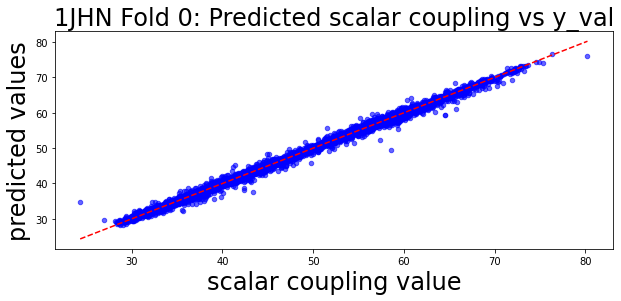

Coupling_Type: 1JHN Fold 1
 Mean_coupling_constant: 47.50823211669922 
 Standard_deviation: 10.982617285475946
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.428898	valid_1's l1: 0.513649
[200]	training's l1: 0.357025	valid_1's l1: 0.468975
[300]	training's l1: 0.308628	valid_1's l1: 0.44349
[400]	training's l1: 0.273407	valid_1's l1: 0.428398
[500]	training's l1: 0.245509	valid_1's l1: 0.41799
[600]	training's l1: 0.223738	valid_1's l1: 0.410541
[700]	training's l1: 0.205834	valid_1's l1: 0.404961
[800]	training's l1: 0.189627	valid_1's l1: 0.400281
[900]	training's l1: 0.176337	valid_1's l1: 0.397189
[1000]	training's l1: 0.164774	valid_1's l1: 0.393788
[1100]	training's l1: 0.154117	valid_1's l1: 0.391421
[1200]	training's l1: 0.14376	valid_1's l1: 0.389177
[1300]	training's l1: 0.135358	valid_1's l1: 0.387472
[1400]	training's l1: 0.127137	valid_1's l1: 0.385636
[1500]	training's l1: 0.119757	valid_1's l1: 0.384557
Did not meet early stopping. 

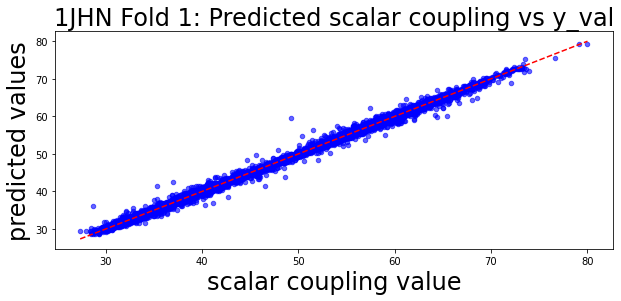

Coupling_Type: 1JHN Fold 2
 Mean_coupling_constant: 47.502559661865234 
 Standard_deviation: 10.928106764825104
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.415167	valid_1's l1: 0.517297
[200]	training's l1: 0.345792	valid_1's l1: 0.475563
[300]	training's l1: 0.298733	valid_1's l1: 0.450718
[400]	training's l1: 0.266333	valid_1's l1: 0.436512
[500]	training's l1: 0.241947	valid_1's l1: 0.426586
[600]	training's l1: 0.221801	valid_1's l1: 0.41867
[700]	training's l1: 0.2038	valid_1's l1: 0.412611
[800]	training's l1: 0.189152	valid_1's l1: 0.408098
[900]	training's l1: 0.175797	valid_1's l1: 0.403809
[1000]	training's l1: 0.163979	valid_1's l1: 0.400459
[1100]	training's l1: 0.153071	valid_1's l1: 0.398013
[1200]	training's l1: 0.143732	valid_1's l1: 0.39587
[1300]	training's l1: 0.13542	valid_1's l1: 0.393667
[1400]	training's l1: 0.127334	valid_1's l1: 0.392157
[1500]	training's l1: 0.120063	valid_1's l1: 0.390025
Did not meet early stopping. B

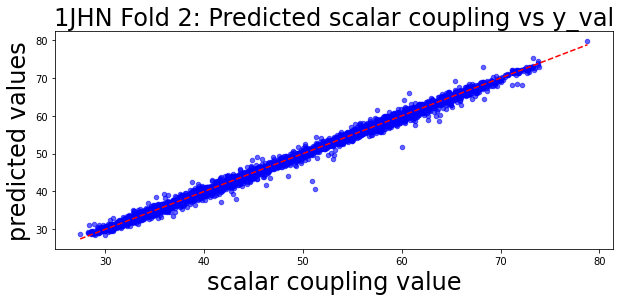

*** Training Model for 1JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Coupling_Type: 1JHC Fold 0
 Mean_coupling_constant: 94.97134399414062 
 Standard_deviation: 18.369221351858204
Traini

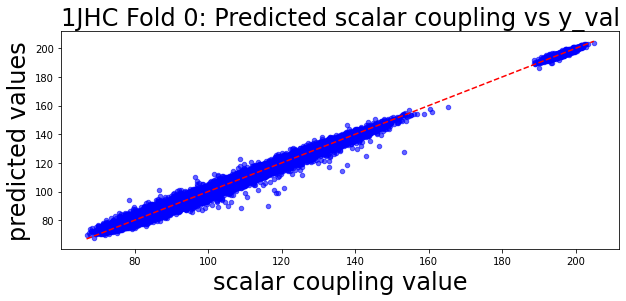

Coupling_Type: 1JHC Fold 1
 Mean_coupling_constant: 94.99655151367188 
 Standard_deviation: 18.323208440193
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.16643	valid_1's l1: 1.21149
[200]	training's l1: 0.995569	valid_1's l1: 1.06838
[300]	training's l1: 0.898964	valid_1's l1: 0.996036
[400]	training's l1: 0.826048	valid_1's l1: 0.944302
[500]	training's l1: 0.773213	valid_1's l1: 0.909688
[600]	training's l1: 0.730683	valid_1's l1: 0.883719
[700]	training's l1: 0.693609	valid_1's l1: 0.861843
[800]	training's l1: 0.66178	valid_1's l1: 0.844265
[900]	training's l1: 0.63375	valid_1's l1: 0.829832
[1000]	training's l1: 0.608966	valid_1's l1: 0.817022
[1100]	training's l1: 0.586443	valid_1's l1: 0.805945
[1200]	training's l1: 0.566629	valid_1's l1: 0.796783
[1300]	training's l1: 0.547791	valid_1's l1: 0.788112
[1400]	training's l1: 0.530249	valid_1's l1: 0.780179
[1500]	training's l1: 0.514248	valid_1's l1: 0.772898
Did not meet early stopping. Best 

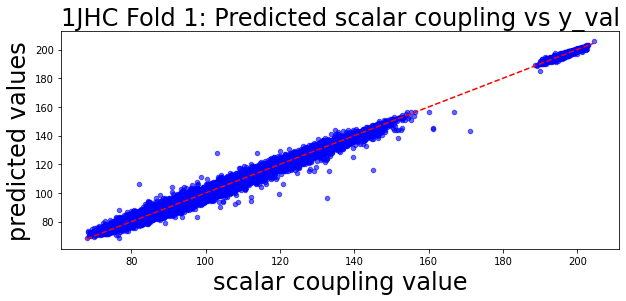

Coupling_Type: 1JHC Fold 2
 Mean_coupling_constant: 94.91748046875 
 Standard_deviation: 18.169264205308536
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.17136	valid_1's l1: 1.22957
[200]	training's l1: 0.993166	valid_1's l1: 1.08025
[300]	training's l1: 0.895393	valid_1's l1: 1.0059
[400]	training's l1: 0.825661	valid_1's l1: 0.956498
[500]	training's l1: 0.771541	valid_1's l1: 0.920698
[600]	training's l1: 0.726472	valid_1's l1: 0.892737
[700]	training's l1: 0.690532	valid_1's l1: 0.871731
[800]	training's l1: 0.659135	valid_1's l1: 0.854657
[900]	training's l1: 0.631238	valid_1's l1: 0.840036
[1000]	training's l1: 0.607534	valid_1's l1: 0.827715
[1100]	training's l1: 0.585228	valid_1's l1: 0.816895
[1200]	training's l1: 0.564779	valid_1's l1: 0.807382
[1300]	training's l1: 0.546074	valid_1's l1: 0.798803
[1400]	training's l1: 0.528433	valid_1's l1: 0.790966
[1500]	training's l1: 0.512404	valid_1's l1: 0.783873
Did not meet early stopping. Best 

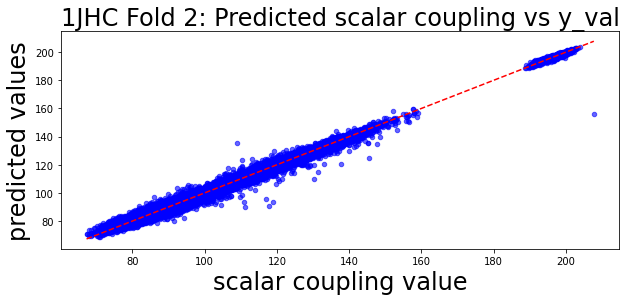

*** Training Model for 2JHH ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Coupling_Type: 2JHH Fold 0
 Mean_coupling_constant: -10.261480331420898 
 Standard_deviation: 3.986466267061872
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.25478	valid_1's l1:

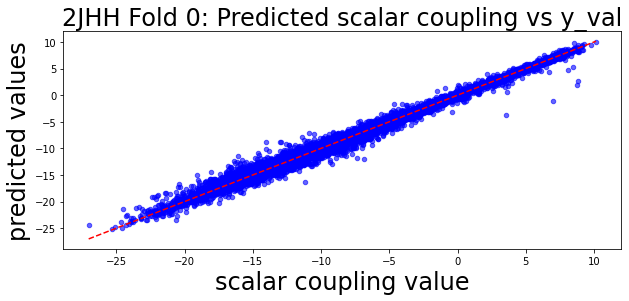

Coupling_Type: 2JHH Fold 1
 Mean_coupling_constant: -10.27208137512207 
 Standard_deviation: 4.010544557633323
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.256724	valid_1's l1: 0.27851
[200]	training's l1: 0.208258	valid_1's l1: 0.240837
[300]	training's l1: 0.183862	valid_1's l1: 0.224272
[400]	training's l1: 0.166755	valid_1's l1: 0.214206
[500]	training's l1: 0.153784	valid_1's l1: 0.207017
[600]	training's l1: 0.142963	valid_1's l1: 0.201594
[700]	training's l1: 0.13396	valid_1's l1: 0.197295
[800]	training's l1: 0.126406	valid_1's l1: 0.193727
[900]	training's l1: 0.119794	valid_1's l1: 0.190661
[1000]	training's l1: 0.113657	valid_1's l1: 0.188017
[1100]	training's l1: 0.108392	valid_1's l1: 0.186015
[1200]	training's l1: 0.103478	valid_1's l1: 0.183989
[1300]	training's l1: 0.0991733	valid_1's l1: 0.182444
[1400]	training's l1: 0.0952255	valid_1's l1: 0.181059
[1500]	training's l1: 0.0913593	valid_1's l1: 0.179598
Did not meet early stoppi

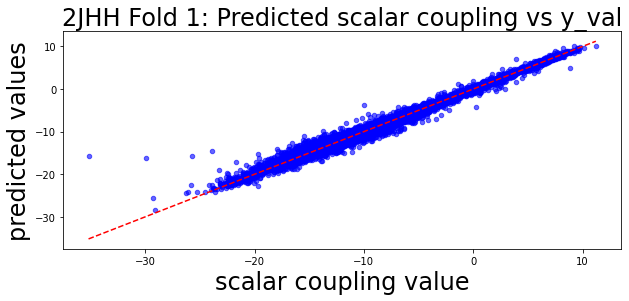

Coupling_Type: 2JHH Fold 2
 Mean_coupling_constant: -10.279756546020508 
 Standard_deviation: 3.9811763080228144
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.255016	valid_1's l1: 0.278009
[200]	training's l1: 0.207183	valid_1's l1: 0.241817
[300]	training's l1: 0.182499	valid_1's l1: 0.225547
[400]	training's l1: 0.165791	valid_1's l1: 0.215202
[500]	training's l1: 0.153373	valid_1's l1: 0.208721
[600]	training's l1: 0.142812	valid_1's l1: 0.20324
[700]	training's l1: 0.133947	valid_1's l1: 0.19887
[800]	training's l1: 0.126417	valid_1's l1: 0.19542
[900]	training's l1: 0.120258	valid_1's l1: 0.192667
[1000]	training's l1: 0.114243	valid_1's l1: 0.190156
[1100]	training's l1: 0.108889	valid_1's l1: 0.188056
[1200]	training's l1: 0.104133	valid_1's l1: 0.1862
[1300]	training's l1: 0.0996255	valid_1's l1: 0.184409
[1400]	training's l1: 0.095612	valid_1's l1: 0.182846
[1500]	training's l1: 0.0917998	valid_1's l1: 0.181413
Did not meet early stopping

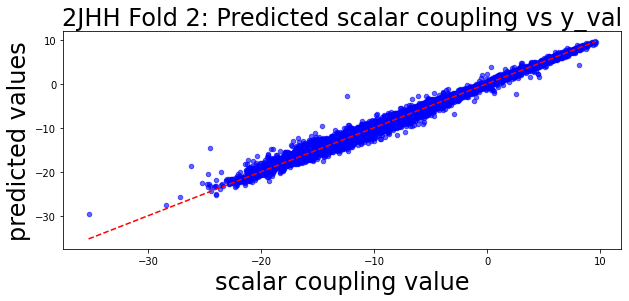

*** Training Model for 2JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Coupling_Type: 2JHN Fold 0
 Mean_coupling_constant: 3.1181743144989014 
 Standard_deviation: 3.6809712103001573
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185848	valid_1's l1

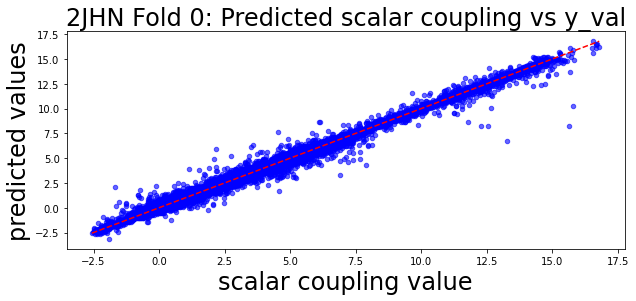

Coupling_Type: 2JHN Fold 1
 Mean_coupling_constant: 3.0940499305725098 
 Standard_deviation: 3.657754526843057
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185665	valid_1's l1: 0.214964
[200]	training's l1: 0.150319	valid_1's l1: 0.191201
[300]	training's l1: 0.130522	valid_1's l1: 0.179194
[400]	training's l1: 0.116941	valid_1's l1: 0.172006
[500]	training's l1: 0.106583	valid_1's l1: 0.166903
[600]	training's l1: 0.0980389	valid_1's l1: 0.162721
[700]	training's l1: 0.0907663	valid_1's l1: 0.159567
[800]	training's l1: 0.0843704	valid_1's l1: 0.156996
[900]	training's l1: 0.0791237	valid_1's l1: 0.155108
[1000]	training's l1: 0.0745085	valid_1's l1: 0.153258
[1100]	training's l1: 0.0701277	valid_1's l1: 0.151667
[1200]	training's l1: 0.0662392	valid_1's l1: 0.150257
[1300]	training's l1: 0.0626189	valid_1's l1: 0.14912
[1400]	training's l1: 0.0591547	valid_1's l1: 0.147903
[1500]	training's l1: 0.056011	valid_1's l1: 0.146915
Did not meet early

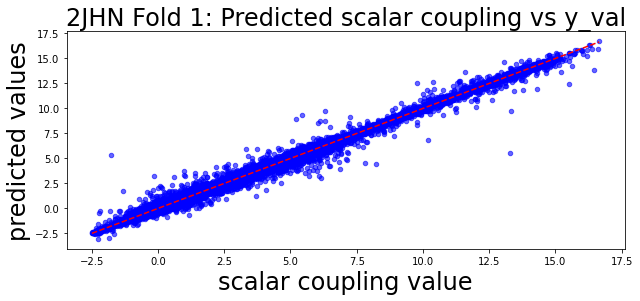

Coupling_Type: 2JHN Fold 2
 Mean_coupling_constant: 3.1159801483154297 
 Standard_deviation: 3.6640538281792896
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.187415	valid_1's l1: 0.216974
[200]	training's l1: 0.151248	valid_1's l1: 0.191189
[300]	training's l1: 0.13171	valid_1's l1: 0.179676
[400]	training's l1: 0.117465	valid_1's l1: 0.171606
[500]	training's l1: 0.106143	valid_1's l1: 0.166008
[600]	training's l1: 0.0975134	valid_1's l1: 0.161981
[700]	training's l1: 0.0903942	valid_1's l1: 0.158911
[800]	training's l1: 0.0840283	valid_1's l1: 0.156288
[900]	training's l1: 0.0785385	valid_1's l1: 0.154075
[1000]	training's l1: 0.0733406	valid_1's l1: 0.152219
[1100]	training's l1: 0.0690523	valid_1's l1: 0.150667
[1200]	training's l1: 0.0650313	valid_1's l1: 0.149135
[1300]	training's l1: 0.0614842	valid_1's l1: 0.147988
[1400]	training's l1: 0.0581044	valid_1's l1: 0.146942
[1500]	training's l1: 0.0552373	valid_1's l1: 0.146005
Did not meet ear

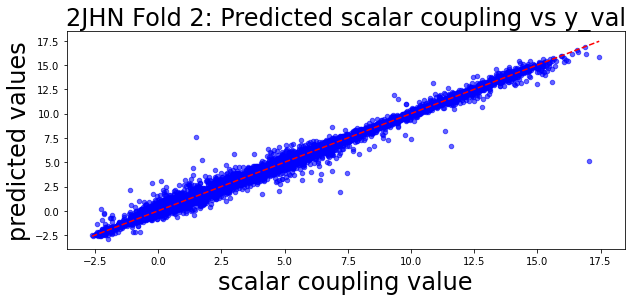

*** Training Model for 2JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Coupling_Type: 2JHC Fold 0
 Mean_coupling_constant: -0.2852455675601959 
 Standard_deviation: 4.517100000441426
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.498644	valid_1's l1

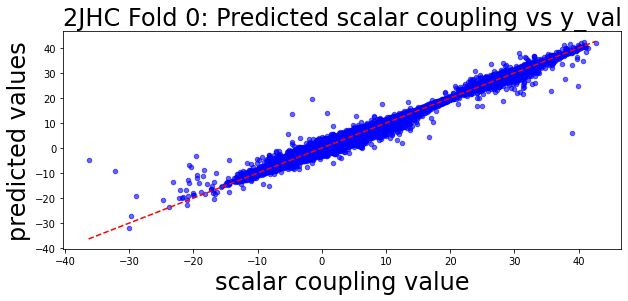

Coupling_Type: 2JHC Fold 1
 Mean_coupling_constant: -0.2682524025440216 
 Standard_deviation: 4.531127568775017
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.500216	valid_1's l1: 0.513556
[200]	training's l1: 0.423355	valid_1's l1: 0.445804
[300]	training's l1: 0.382393	valid_1's l1: 0.411553
[400]	training's l1: 0.354495	valid_1's l1: 0.38937
[500]	training's l1: 0.333251	valid_1's l1: 0.373266
[600]	training's l1: 0.316417	valid_1's l1: 0.360953
[700]	training's l1: 0.301997	valid_1's l1: 0.350789
[800]	training's l1: 0.290079	valid_1's l1: 0.342607
[900]	training's l1: 0.279171	valid_1's l1: 0.335269
[1000]	training's l1: 0.269624	valid_1's l1: 0.329398
[1100]	training's l1: 0.261338	valid_1's l1: 0.324134
[1200]	training's l1: 0.253423	valid_1's l1: 0.319245
[1300]	training's l1: 0.246229	valid_1's l1: 0.315216
[1400]	training's l1: 0.239663	valid_1's l1: 0.311411
[1500]	training's l1: 0.233499	valid_1's l1: 0.307963
Did not meet early stoppin

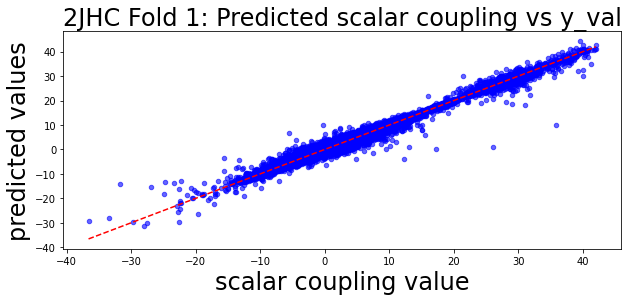

Coupling_Type: 2JHC Fold 2
 Mean_coupling_constant: -0.27479496598243713 
 Standard_deviation: 4.512670532205168
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.500116	valid_1's l1: 0.515273
[200]	training's l1: 0.423144	valid_1's l1: 0.446792
[300]	training's l1: 0.381571	valid_1's l1: 0.411959
[400]	training's l1: 0.353442	valid_1's l1: 0.389358
[500]	training's l1: 0.332349	valid_1's l1: 0.373177
[600]	training's l1: 0.315809	valid_1's l1: 0.360845
[700]	training's l1: 0.301542	valid_1's l1: 0.350611
[800]	training's l1: 0.289334	valid_1's l1: 0.342256
[900]	training's l1: 0.278865	valid_1's l1: 0.335255
[1000]	training's l1: 0.26977	valid_1's l1: 0.329391
[1100]	training's l1: 0.261214	valid_1's l1: 0.323926
[1200]	training's l1: 0.253409	valid_1's l1: 0.319125
[1300]	training's l1: 0.246221	valid_1's l1: 0.314861
[1400]	training's l1: 0.239594	valid_1's l1: 0.310978
[1500]	training's l1: 0.233622	valid_1's l1: 0.307585
Did not meet early stoppi

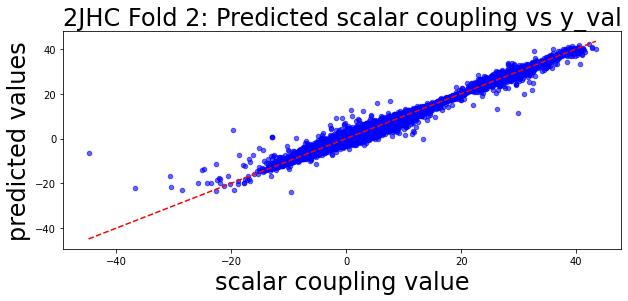

*** Training Model for 3JHH ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Coupling_Type: 3JHH Fold 0
 Mean_coupling_constant: 4.789495468139648 
 Standard_deviation: 3.721727569959567
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.282135	valid_1's l1: 

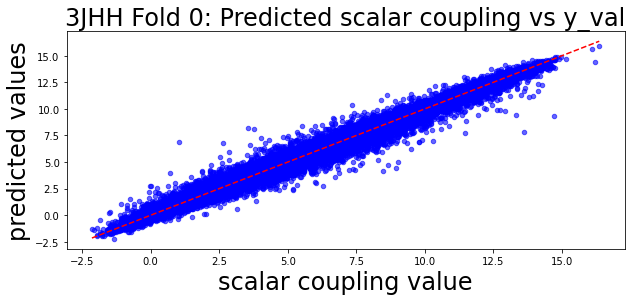

Coupling_Type: 3JHH Fold 1
 Mean_coupling_constant: 4.752202033996582 
 Standard_deviation: 3.7025006636350546
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.283772	valid_1's l1: 0.297585
[200]	training's l1: 0.232114	valid_1's l1: 0.253443
[300]	training's l1: 0.206357	valid_1's l1: 0.233226
[400]	training's l1: 0.188266	valid_1's l1: 0.220081
[500]	training's l1: 0.174498	valid_1's l1: 0.210659
[600]	training's l1: 0.164274	valid_1's l1: 0.203967
[700]	training's l1: 0.155481	valid_1's l1: 0.198572
[800]	training's l1: 0.147811	valid_1's l1: 0.194257
[900]	training's l1: 0.141258	valid_1's l1: 0.190685
[1000]	training's l1: 0.135308	valid_1's l1: 0.187572
[1100]	training's l1: 0.13004	valid_1's l1: 0.184775
[1200]	training's l1: 0.125163	valid_1's l1: 0.182306
[1300]	training's l1: 0.120724	valid_1's l1: 0.180295
[1400]	training's l1: 0.116656	valid_1's l1: 0.178431
[1500]	training's l1: 0.112925	valid_1's l1: 0.176803
Did not meet early stopping

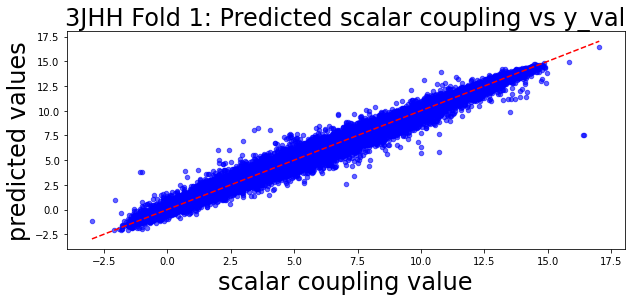

Coupling_Type: 3JHH Fold 2
 Mean_coupling_constant: 4.774511337280273 
 Standard_deviation: 3.7117059824286036
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.281145	valid_1's l1: 0.294677
[200]	training's l1: 0.231764	valid_1's l1: 0.252505
[300]	training's l1: 0.20637	valid_1's l1: 0.232794
[400]	training's l1: 0.188647	valid_1's l1: 0.220029
[500]	training's l1: 0.175523	valid_1's l1: 0.211182
[600]	training's l1: 0.164661	valid_1's l1: 0.204143
[700]	training's l1: 0.155787	valid_1's l1: 0.198576
[800]	training's l1: 0.148092	valid_1's l1: 0.194079
[900]	training's l1: 0.141357	valid_1's l1: 0.190362
[1000]	training's l1: 0.13528	valid_1's l1: 0.187134
[1100]	training's l1: 0.12995	valid_1's l1: 0.184325
[1200]	training's l1: 0.125112	valid_1's l1: 0.181889
[1300]	training's l1: 0.120593	valid_1's l1: 0.179679
[1400]	training's l1: 0.116466	valid_1's l1: 0.177711
[1500]	training's l1: 0.112715	valid_1's l1: 0.175919
Did not meet early stopping. 

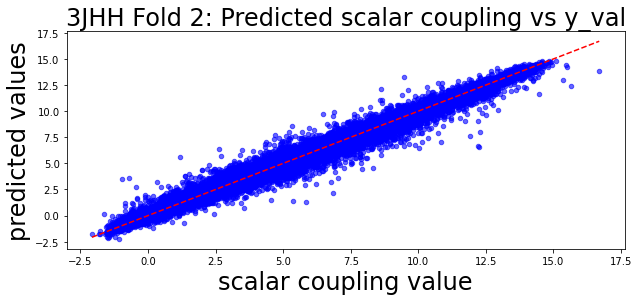

*** Training Model for 3JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Coupling_Type: 3JHC Fold 0
 Mean_coupling_constant: 3.6816370487213135 
 Standard_deviation: 3.071306923206031
Traini

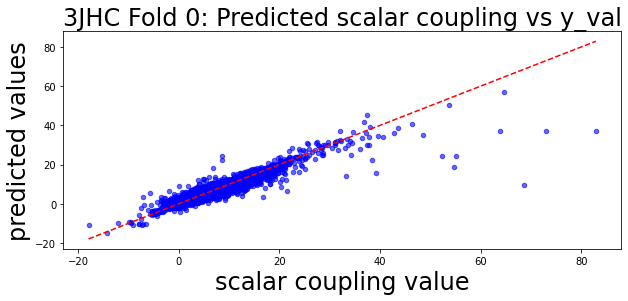

Coupling_Type: 3JHC Fold 1
 Mean_coupling_constant: 3.694019079208374 
 Standard_deviation: 3.0774669351418726
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.55718	valid_1's l1: 0.569063
[200]	training's l1: 0.473722	valid_1's l1: 0.492782
[300]	training's l1: 0.431783	valid_1's l1: 0.456378
[400]	training's l1: 0.401738	valid_1's l1: 0.431326
[500]	training's l1: 0.379737	valid_1's l1: 0.413722
[600]	training's l1: 0.3621	valid_1's l1: 0.400076
[700]	training's l1: 0.347459	valid_1's l1: 0.389255
[800]	training's l1: 0.334599	valid_1's l1: 0.380028
[900]	training's l1: 0.323543	valid_1's l1: 0.372348
[1000]	training's l1: 0.313502	valid_1's l1: 0.365498
[1100]	training's l1: 0.304566	valid_1's l1: 0.359599
[1200]	training's l1: 0.29627	valid_1's l1: 0.354242
[1300]	training's l1: 0.2888	valid_1's l1: 0.349415
[1400]	training's l1: 0.281764	valid_1's l1: 0.345067
[1500]	training's l1: 0.275368	valid_1's l1: 0.341159
Did not meet early stopping. Bes

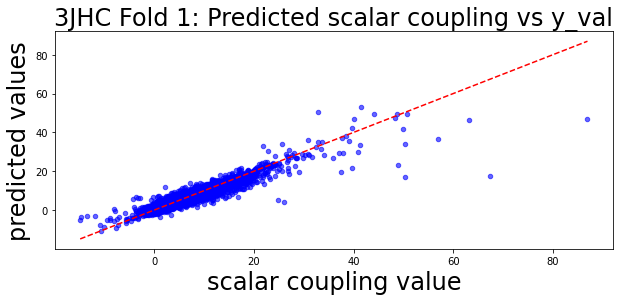

Coupling_Type: 3JHC Fold 2
 Mean_coupling_constant: 3.6864030361175537 
 Standard_deviation: 3.0790618918227843
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.552116	valid_1's l1: 0.563562
[200]	training's l1: 0.473118	valid_1's l1: 0.491109
[300]	training's l1: 0.429292	valid_1's l1: 0.453044
[400]	training's l1: 0.400259	valid_1's l1: 0.42889
[500]	training's l1: 0.378794	valid_1's l1: 0.411644
[600]	training's l1: 0.360712	valid_1's l1: 0.397632
[700]	training's l1: 0.345873	valid_1's l1: 0.38648
[800]	training's l1: 0.333268	valid_1's l1: 0.377521
[900]	training's l1: 0.322201	valid_1's l1: 0.369898
[1000]	training's l1: 0.312549	valid_1's l1: 0.363331
[1100]	training's l1: 0.303558	valid_1's l1: 0.357417
[1200]	training's l1: 0.295402	valid_1's l1: 0.352134
[1300]	training's l1: 0.287959	valid_1's l1: 0.347609
[1400]	training's l1: 0.281025	valid_1's l1: 0.34346
[1500]	training's l1: 0.274724	valid_1's l1: 0.33974
Did not meet early stopping. 

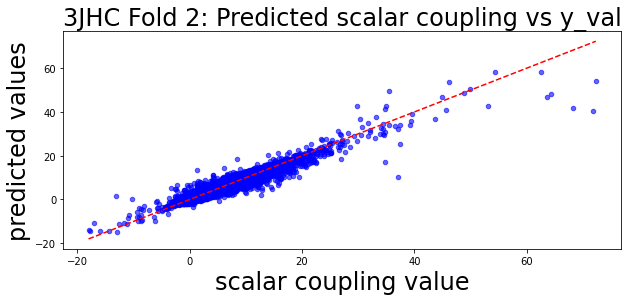

*** Training Model for 3JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Coupling_Type: 3JHN Fold 0
 Mean_coupling_constant: 0.9959847331047058 
 Standard_deviation: 1.3271657422974152
Train

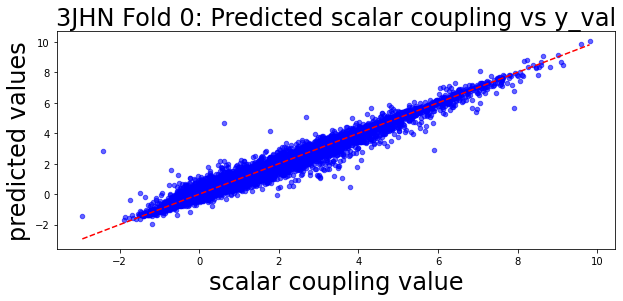

Coupling_Type: 3JHN Fold 1
 Mean_coupling_constant: 0.9919647574424744 
 Standard_deviation: 1.3141757966381116
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.149568	valid_1's l1: 0.170869
[200]	training's l1: 0.120123	valid_1's l1: 0.150163
[300]	training's l1: 0.103161	valid_1's l1: 0.139754
[400]	training's l1: 0.0916766	valid_1's l1: 0.133527
[500]	training's l1: 0.0832016	valid_1's l1: 0.129196
[600]	training's l1: 0.0758384	valid_1's l1: 0.125614
[700]	training's l1: 0.0697818	valid_1's l1: 0.123025
[800]	training's l1: 0.0646436	valid_1's l1: 0.120779
[900]	training's l1: 0.060288	valid_1's l1: 0.119017
[1000]	training's l1: 0.0562625	valid_1's l1: 0.11737
[1100]	training's l1: 0.0527008	valid_1's l1: 0.116105
[1200]	training's l1: 0.0494534	valid_1's l1: 0.115012
[1300]	training's l1: 0.0467104	valid_1's l1: 0.114103
[1400]	training's l1: 0.0441653	valid_1's l1: 0.113288
[1500]	training's l1: 0.0418937	valid_1's l1: 0.112589
Did not meet ea

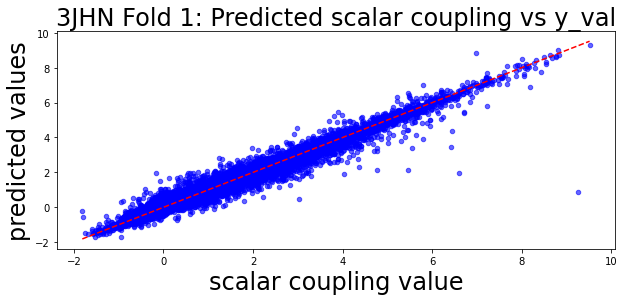

Coupling_Type: 3JHN Fold 2
 Mean_coupling_constant: 0.9944908022880554 
 Standard_deviation: 1.3155870015817148
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.149837	valid_1's l1: 0.171885
[200]	training's l1: 0.120679	valid_1's l1: 0.151379
[300]	training's l1: 0.103966	valid_1's l1: 0.141074
[400]	training's l1: 0.0925679	valid_1's l1: 0.134913
[500]	training's l1: 0.0836004	valid_1's l1: 0.130765
[600]	training's l1: 0.0764838	valid_1's l1: 0.127528
[700]	training's l1: 0.0706189	valid_1's l1: 0.124977
[800]	training's l1: 0.0653721	valid_1's l1: 0.122681
[900]	training's l1: 0.0608933	valid_1's l1: 0.121047
[1000]	training's l1: 0.0571009	valid_1's l1: 0.119606
[1100]	training's l1: 0.0535071	valid_1's l1: 0.118237
[1200]	training's l1: 0.050392	valid_1's l1: 0.117139
[1300]	training's l1: 0.047431	valid_1's l1: 0.116177
[1400]	training's l1: 0.0448017	valid_1's l1: 0.115298
[1500]	training's l1: 0.0424007	valid_1's l1: 0.114576
Did not meet ea

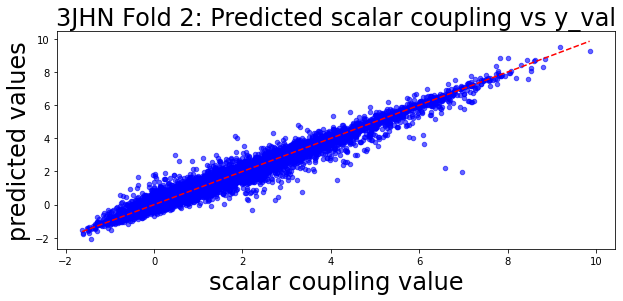

Finished running successfully
CPU times: user 2h 39min 16s, sys: 1min 21s, total: 2h 40min 37s
Wall time: 2h 41min 59s


In [43]:
%%time

model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
output_result = output_result_csv.copy()
# https://beginnersbook.com/2019/03/python-set-copy-method/

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, output_result, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score
print("Finished running successfully")

Checking cross-validation scores for each type:

In [44]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score ( ln )': list(cv_scores.values())})

,type,cv_score ( ln )
0,1JHN,-0.955175
1,1JHC,-0.249954
2,2JHH,-1.712283
3,2JHN,-1.919815
4,2JHC,-1.177534
5,3JHH,-1.734137
6,3JHC,-1.077339
7,3JHN,-2.179759


In [45]:
import math

pd.DataFrame({'type': list(cv_scores.keys()), 'mean_absolute_error': [ math.exp(el) for el in list(cv_scores.values())]})

,type,mean_absolute_error
0,1JHN,0.384745
1,1JHC,0.778837
2,2JHH,0.180453
3,2JHN,0.146634
4,2JHC,0.308037
5,3JHH,0.176552
6,3JHC,0.340501
7,3JHN,0.113069


In [46]:
output_result.head(10)

,scalar_coupling_constant
id,
4659076,18.851437
4659077,157.014709
4659078,9.212738
4659079,157.014709
4659080,18.851437
4659081,85.328156
4659082,-3.977123
4659083,-10.801984
4659084,-11.482528


In [47]:
output_result.to_csv('output_result.csv')

## Room for improvement


* Tune LGB hyperparameters
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries
* Consider angles among bonds
* Include more surrounding atoms
